In [1]:
import numpy as np
import pandas as pd
import os
import re
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold, ShuffleSplit
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from colorama import Fore, Style
from IPython.display import clear_output
import warnings
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from pytorch_tabnet.tab_model import TabNetRegressor
import gc
gc.enable()
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

pl.Config.set_tbl_rows(-1)
pl.Config.set_tbl_cols(-1)
pl.Config.set_fmt_str_lengths(10000)

polars.config.Config

# Preprocessing & Feature Engineering

In [2]:
#from IPython.display import display as ipydisplay, HTML
#ipydisplay(HTML("<style>.jp-CodeCell.jp-mod-outputsScrolled .jp-Cell-outputArea { max-height: 80em; }</style>"))

In [3]:
SEED = 42
n_splits = 5

In [4]:
path = "I:/Kaggle/child-mind-institute-problematic-internet-use/"

In [5]:
train = pd.read_csv(path + 'train.csv', dtype={'id': str})
test = pd.read_csv(path + 'test.csv', dtype={'id': str})
#sample = pd.read_csv(path + 'sample_submission.csv', dtype={'id': str})

In [6]:
data_dict = pd.read_csv(path + 'data_dictionary.csv')

In [7]:
train_target = train[test.columns]

In [8]:
concat_df = pd.concat([train_target, test], ignore_index=True)

In [9]:
concat_df['total_num_nan'] = concat_df.isna().sum(axis=1)

In [10]:
del train_target
gc.collect()

0

In [11]:
nan_df = concat_df[concat_df['total_num_nan'] == concat_df['total_num_nan'].max()]

In [12]:
for col in concat_df.columns:
    if col == 'id':
        continue
    new_col_name = col + '_isnan'
    concat_df[new_col_name] = concat_df[col].isna().astype(int)

In [13]:
instruments = data_dict['Instrument'].unique().tolist()
instruments.remove('Identifier')

In [14]:
for instrument in instruments:
    if 'Parent-Child Internet Addiction Test' == instrument:
        continue
    instrument_df = data_dict[data_dict['Instrument'] == instrument]
    field_list = instrument_df['Field'].unique().tolist()
    concat_df[instrument + '_num_nan'] = concat_df[field_list].isna().sum(axis=1)

del instrument_df, field_list
gc.collect()

0

In [15]:
train_parquet_id_folders_list = os.listdir(path + 'series_train.parquet/')

In [16]:
train_parquet_id_list = [v.replace('id=', '') for v in train_parquet_id_folders_list]

In [17]:
test_parquet_id_folders_list = os.listdir(path + 'series_test.parquet/')

In [18]:
test_parquet_id_list = [v.replace('id=', '') for v in test_parquet_id_folders_list]

In [19]:
train_temp_df = concat_df.head(train.shape[0]).reset_index(drop=True)

In [20]:
test_temp_df = concat_df.tail(test.shape[0]).reset_index(drop=True)

In [21]:
del concat_df
gc.collect()

0

In [22]:
train_temp_df['has_parquet'] = train_temp_df['id'].isin(train_parquet_id_list).astype(int)

In [23]:
test_temp_df['has_parquet'] = test_temp_df['id'].isin(test_parquet_id_list).astype(int)

In [24]:
# https://www.kaggle.com/code/antoninadolgorukova/cmi-piu-actigraphy-data-eda
entropy = lambda x: -(x / x.sum() * np.log(x / x.sum() + 1e-9)).sum()

In [25]:
def feat_engi(df, target_cols):
    stats_df = df[target_cols].describe(percentiles=[0.01, 0.03] + [(i+1)*0.05 for i in range(19)] + [0.97, 0.99]).T
    count = stats_df['count'][0]
    stats_df.drop('count', axis=1, inplace=True)
    
    column_names_list = []
    for idx in stats_df.index:
        for col in stats_df.columns:
            column_names_list.append(str(idx) + '_' + str(col))

    reshaped_df = pd.DataFrame(stats_df.values.reshape(-1)).T.reset_index(drop=True)
    reshaped_df.columns = column_names_list

    reshaped_df['count'] = count

    return reshaped_df

In [26]:
def groupby_feat_engi(df, col_to_group, target_col):
    stats_df = pd.DataFrame(
        df.groupby(col_to_group)[target_col].describe(percentiles=[0.01, 0.03] + [(i+1)*0.05 for i in range(19)] + [0.97, 0.99])
    )

    stats_df['sum'] = df.groupby(col_to_group)[target_col].sum()
    stats_df['entropy'] = df.groupby(col_to_group)[target_col].apply(entropy)
    
    column_names_list = []
    for idx in stats_df.index:
        for col in stats_df.columns:
            column_names_list.append(target_col + '_' + col_to_group + '_' + str(idx) + '_' + str(col))

    reshaped_df = pd.DataFrame(stats_df.values.reshape(-1)).T.reset_index(drop=True)
    reshaped_df.columns = column_names_list

    return reshaped_df

In [27]:
def uncommon_groupby_feat_engi(df, col_to_group, target_col):
    stats_df = pd.DataFrame(
        df.groupby(col_to_group)[target_col].describe()
        #df.groupby(col_to_group)[target_col].describe(percentiles=[0.01, 0.03] + [(i+1)*0.05 for i in range(19)] + [0.97, 0.99])
    )

    stats_df['sum'] = df.groupby(col_to_group)[target_col].sum()
    stats_df['entropy'] = df.groupby(col_to_group)[target_col].apply(entropy)

    
    #stats_stats_df = stats_df.describe(percentiles=[0.01, 0.03] + [(i+1)*0.05 for i in range(19)] + [0.97, 0.99])
    stats_stats_df = stats_df.describe()
    stats_stats_count = stats_stats_df['count'][0]
    stats_stats_df.drop('count', axis=0, inplace=True)
    stats_stats_df = stats_stats_df.T
    
    column_names_list = []
    for idx in stats_stats_df.index:
        for col in stats_stats_df.columns:
            column_names_list.append(target_col + '_' + col_to_group + '_' + str(idx) + '_' + str(col))
    
    reshaped_df = pd.DataFrame(stats_stats_df.values.reshape(-1)).T.reset_index(drop=True)
    reshaped_df.columns = column_names_list

    current_cols = reshaped_df.columns.tolist()
    count_col_name = target_col + '_' + col_to_group + '_count'
    reshaped_df[count_col_name] = stats_stats_count

    reshaped_df = reshaped_df[[count_col_name] + current_cols]

    return reshaped_df

In [28]:
def read_parquet(dataset='train'):
    parquet_id_folders_list = os.listdir(path + 'series_' + dataset + '.parquet/')
    ts_list = []
    ts_features_list = []
    for id_folder in tqdm(parquet_id_folders_list):
        iid = id_folder.replace('id=', '')
    
        parquet_files_path = path + 'series_' + dataset + '.parquet/' + id_folder + '/'
        parquet_files_list = os.listdir(parquet_files_path)
    
        dfs_list = []
        for parquet_filename in parquet_files_list:
            if '.parquet' in parquet_filename:
                parquet_df = pd.read_parquet(parquet_files_path + parquet_filename)
                dfs_list.append(parquet_df)
        parquet_concat_df = pd.concat(dfs_list, ignore_index=True)
        current_cols = parquet_concat_df.columns.tolist()
        
        parquet_concat_df['id'] = iid
        
        parquet_concat_df = parquet_concat_df[['id'] + current_cols]
        
        parquet_concat_df['day_since_wear'] = (parquet_concat_df['relative_date_PCIAT'] - parquet_concat_df['relative_date_PCIAT'].min()).astype(int)
        parquet_concat_df['time_of_day_sec'] = parquet_concat_df['time_of_day'] / 1e9
        parquet_concat_df.drop('time_of_day', axis=1, inplace=True)
        parquet_concat_df['time_of_day_min'] = parquet_concat_df['time_of_day_sec'] / 60
        parquet_concat_df['time_of_day_hour'] = parquet_concat_df['time_of_day_min'] / 60
        parquet_concat_df['time_of_day_day'] = parquet_concat_df['time_of_day_hour'] / 24
        parquet_concat_df['time_of_day_hour_window'] = parquet_concat_df['time_of_day_hour'].astype(int)
        parquet_concat_df['time_of_day_min_window'] = parquet_concat_df['time_of_day_min'].astype(int)
        parquet_concat_df['time_of_day_15_min_window'] = (parquet_concat_df['time_of_day_min'] / 15).astype(int)
        parquet_concat_df['timestamp_day'] = parquet_concat_df['day_since_wear'] + parquet_concat_df['time_of_day_day']
    
        if parquet_concat_df['timestamp_day'].nunique() != parquet_concat_df.shape[0]:
            print('yes')
    
        parquet_concat_df['timestamp_hour'] = parquet_concat_df['timestamp_day'] * 24
        parquet_concat_df['timestamp_min'] = parquet_concat_df['timestamp_day'] * 24 * 60
        parquet_concat_df['timestamp_sec'] = parquet_concat_df['timestamp_day'] * 24 * 60 * 60
        parquet_concat_df['timestamp_15_min'] = parquet_concat_df['timestamp_day'] * 24 * (60/15)
    
        parquet_concat_df['timestamp_hour_window'] = parquet_concat_df['timestamp_hour'].astype(int)
        parquet_concat_df['timestamp_min_window'] = parquet_concat_df['timestamp_min'].astype(int)
        parquet_concat_df['timestamp_15_min_window'] = parquet_concat_df['timestamp_15_min'].astype(int)
    
        battery_voltage_start = parquet_concat_df['battery_voltage'][0]
        parquet_concat_df['battery_use_since_wear'] = -(parquet_concat_df['battery_voltage'] - battery_voltage_start)
        
    
        worn_df = parquet_concat_df[parquet_concat_df['non-wear_flag'] == 0].reset_index(drop=True)
    
        
        feature_cols = ['X', 'Y', 'Z', 'enmo', 'anglez', 'light', 'battery_use_since_wear']
    
        features_df = feat_engi(worn_df, feature_cols)
    
        groupby_cols = ['weekday', 'time_of_day_hour_window']#, 'time_of_day_15_min_window']
    
        groupby_df_list = []
        for groupby_col in groupby_cols:
            for feature_col in feature_cols:
                groupby_features_df = groupby_feat_engi(worn_df, groupby_col, feature_col)
                groupby_df_list.append(groupby_features_df)
    
        groupby_concat_df = pd.concat(groupby_df_list, axis=1)
    
        uncommon_groupby_cols = ['day_since_wear', 'timestamp_hour_window']#, 'timestamp_15_min_window']#, 'timestamp_min_window']
    
        uncommon_groupby_df_list = []
        for uncommon_groupby_col in uncommon_groupby_cols:
            for unc_feature_col in feature_cols:
                uncommon_groupby_df = uncommon_groupby_feat_engi(worn_df, uncommon_groupby_col, unc_feature_col)
                uncommon_groupby_df_list.append(uncommon_groupby_df)
    
        features_concat_df = pd.concat([features_df, groupby_concat_df, uncommon_groupby_df], axis=1)
        features_current_cols = features_concat_df.columns.tolist()
        features_concat_df['id'] = iid
        features_concat_df = features_concat_df[['id'] + features_current_cols]
    
        for q in [1,2,3,4]:
            if q in worn_df['quarter'].tolist():
                features_concat_df['data_collected_in_quarter_' + str(q)] = 1
            else:
                features_concat_df['data_collected_in_quarter_' + str(q)] = 0

        features_concat_df['id'] = features_concat_df['id'].astype(str)

        #features_concat_df.to_csv(path + 'series_' + dataset + '.parquet/id=' + iid + '/features.csv', index=False)
        
        ts_list.append(parquet_concat_df)
        ts_features_list.append(features_concat_df)

        gc.collect()
    gc.collect()
    
    return ts_list, ts_features_list

In [29]:
def read_features_files():
    temp_dfs_list = []
    ts_features_folders_list = os.listdir(path + 'train_ts_features/')
    for temp_id_folder in tqdm(ts_features_folders_list):
        temp_files_list = os.listdir(path + 'train_ts_features/' + temp_id_folder + '/')
        for temp_filename in temp_files_list:
            if '.csv' in temp_filename:
                temp_df = pd.read_csv(path + 'train_ts_features/' + temp_id_folder + '/' + temp_filename, dtype={'id': str})
                temp_dfs_list.append(temp_df)
    gc.collect()
    return temp_dfs_list

In [30]:
train_ts_features_list = read_features_files()

100%|████████████████████████████████████████████████████████████████████████████████| 996/996 [04:55<00:00,  3.37it/s]


In [31]:
test_ts_list, test_ts_features_list = read_parquet(dataset='test')

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.38s/it]


In [32]:
train_ts_features_concat_df = pd.concat(train_ts_features_list, ignore_index=True)
test_ts_features_concat_df = pd.concat(test_ts_features_list, ignore_index=True)

In [33]:
del train_ts_features_list, test_ts_features_list
gc.collect()

0

In [34]:
train_merge_df = train_temp_df.merge(train_ts_features_concat_df, how='left', on='id')
test_merge_df = test_temp_df.merge(test_ts_features_concat_df, how='left', on='id')

In [35]:
del train_ts_features_concat_df, test_ts_features_concat_df
gc.collect()

0

In [36]:
cat_cols = []
for i in range(data_dict.shape[0]):
    col = data_dict['Field'][i]
    if col == 'id':
        continue
    if (data_dict['Type'][i] == 'str') | ('categori' in data_dict['Type'][i]):
        cat_cols.append(col)

In [37]:
ordinal_variables = ['FGC-FGC_CU_Zone', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone',
                     'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_Frame_num',
                     'PreInt_EduHx-computerinternet_hoursday']

ordinal_variables += [col for col in cat_cols if (('PCIAT' in col)&('Season' not in col))]

In [38]:
cat_cols = list(set(cat_cols) - set(ordinal_variables))
cat_cols = [col for col in cat_cols if 'PCIAT' not in col]

In [39]:
merge_concat_df = pd.concat([train_merge_df, test_merge_df], ignore_index=True)

In [40]:
del train_merge_df, test_merge_df
gc.collect()

0

In [41]:
def remove_pciat_cols(df):
    cols_to_drop = []
    for col in df.columns:
        if 'PCIAT' in col:
            cols_to_drop.append(col)

    df.drop(cols_to_drop, axis=1, inplace=True)
    
    return df

In [42]:
merge_concat_df = remove_pciat_cols(merge_concat_df)

In [43]:
def one_hot_cat_cols(df):
    for col in tqdm(cat_cols):
        df[col] = df[col].fillna('Missing').apply(str)
        unique_list = sorted(df[col].unique().tolist())

        for v in unique_list:
            new_col_name = col + '_' + v
            df[new_col_name] = (df[col] == v).astype(int)
    
    df = df.drop(cat_cols, axis=1)

    return df

In [44]:
merge_concat_df = one_hot_cat_cols(merge_concat_df)

100%|█████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 288.63it/s]


In [45]:
# https://www.kaggle.com/code/ichigoe/lb0-494-with-tabnet
def feature_engineering(df):
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
    df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
    df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
    df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
    df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
    df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
    df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
    df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    
    return df

In [46]:
merge_concat_df = feature_engineering(merge_concat_df)

In [47]:
no_id_cols = [col for col in merge_concat_df.columns if col != 'id']

In [48]:
if np.any(np.isinf(merge_concat_df[no_id_cols])):
    print('inf in data')
    merge_concat_df[no_id_cols] = merge_concat_df[no_id_cols].replace([np.inf, -np.inf], np.nan)

inf in data


In [49]:
imputer = KNNImputer(n_neighbors=5)
merge_concat_df[no_id_cols] = imputer.fit_transform(merge_concat_df[no_id_cols])

In [50]:
del imputer
gc.collect()

0

In [51]:
train_df = merge_concat_df.head(train.shape[0]).reset_index(drop=True)
test_df = merge_concat_df.tail(test.shape[0]).reset_index(drop=True)

In [52]:
train_df['sii'] = train['sii']

In [53]:
del train, test
gc.collect()

0

In [54]:
train_nonan_df = train_df[~train_df['sii'].isna()].reset_index(drop=True)

In [55]:
del train_df
gc.collect()

0

In [56]:
selected_features_df = pd.read_csv(path + 'selected_features.csv')

In [57]:
train_cols = selected_features_df['selected_features'].tolist()

In [58]:
del selected_features_df
gc.collect()

0

In [59]:
test_cols = train_cols.copy()
test_cols.remove('sii')

In [60]:
train_final_df = train_nonan_df[train_cols].copy()
test_final_df = test_df[test_cols].copy()

In [61]:
del train_nonan_df, test_df
gc.collect()

0

# Training

In [62]:
# https://www.kaggle.com/code/ichigoe/lb0-494-with-tabnet
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

In [93]:
# https://www.kaggle.com/code/ichigoe/lb0-494-with-tabnet
# Edited by Max (Jongyun Han)
def catboost_train(train_data, test_data):
    X = train_data.drop(['id', 'sii'], axis=1)
    y = train_data['sii']

    test_data_copy = test_data.copy()
    test_data = test_data.drop('id', axis=1)

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    models_list = []

    catboost_params = {
        'learning_rate': 0.02,
        'depth': 9,
        'iterations': 2000,
        'random_seed': SEED,
        'verbose': 0,
        'l2_leaf_reg': 15,
        'task_type': 'GPU',
        'use_best_model': True,
        'early_stopping_rounds': 30,
        'boosting_type': 'Ordered'
    }

    #for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
    for fold, (train_idx, test_idx) in enumerate(SKF.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = CatBoostRegressor(
            **catboost_params
        )
        
        model.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_KappaOPtimizer = minimize(evaluate_predictions,
                                  x0=[0.5, 1.5, 2.5], args=(y_train, y_train_pred), 
                                  method='Nelder-Mead')
        assert train_KappaOPtimizer.success, "Train Optimization did not converge."

        train_pred_tuned = threshold_Rounder(y_train_pred, train_KappaOPtimizer.x)
        train_Kappa = quadratic_weighted_kappa(y_train, train_pred_tuned)

        print(f"----> || Train Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {train_Kappa:.3f}{Style.RESET_ALL}")

        val_KappaOPtimizer = minimize(evaluate_predictions,
                                  x0=[0.5, 1.5, 2.5], args=(y_val, y_val_pred), 
                                  method='Nelder-Mead')
        assert val_KappaOPtimizer.success, "Val Optimization did not converge."

        val_pred_tuned = threshold_Rounder(y_val_pred, val_KappaOPtimizer.x)
        val_Kappa = quadratic_weighted_kappa(y_val, val_pred_tuned)

        print(f"----> || Val Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {val_Kappa:.3f}{Style.RESET_ALL}")

        train_optimized_val_pred_tuned = threshold_Rounder(y_val_pred, train_KappaOPtimizer.x)
        train_optimized_val_Kappa = quadratic_weighted_kappa(y_val, train_optimized_val_pred_tuned)

        print(f"----> || Train Optimized Val QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {train_optimized_val_Kappa:.3f}{Style.RESET_ALL}")

        val_optimized_train_pred_tuned = threshold_Rounder(y_train_pred, val_KappaOPtimizer.x)
        val_optimized_train_Kappa = quadratic_weighted_kappa(y_train, val_optimized_train_pred_tuned)

        print(f"----> || Val Optimized Train QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {val_optimized_train_Kappa:.3f}{Style.RESET_ALL}")

        rounded_train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        rounded_val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)        

        train_S.append(train_Kappa)
        test_S.append(val_Kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Rounded Train QWK: {rounded_train_kappa:.4f}, Rounded Validation QWK: {rounded_val_kappa:.4f}")
        #clear_output(wait=True)

        models_list.append(model)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': test_data_copy['id'],
        'sii': tpTuned
    })

    return models_list, submission, oof_non_rounded, tpm

In [94]:
cat_models_list, cat_submission_df, cat_raw_train_preds, cat_raw_test_preds = catboost_train(train_final_df, test_final_df)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.803
----> || Val Optimized QWK SCORE ::  0.537
----> || Train Optimized Val QWK SCORE ::  0.512
----> || Val Optimized Train QWK SCORE ::  0.799
Fold 1 - Rounded Train QWK: 0.7562, Rounded Validation QWK: 0.4328


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.742
----> || Val Optimized QWK SCORE ::  0.556
----> || Train Optimized Val QWK SCORE ::  0.543
----> || Val Optimized Train QWK SCORE ::  0.736
Fold 2 - Rounded Train QWK: 0.6617, Rounded Validation QWK: 0.4591


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.723
----> || Val Optimized QWK SCORE ::  0.505
----> || Train Optimized Val QWK SCORE ::  0.470
----> || Val Optimized Train QWK SCORE ::  0.707
Fold 3 - Rounded Train QWK: 0.6475, Rounded Validation QWK: 0.4073


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.716
----> || Val Optimized QWK SCORE ::  0.469
----> || Train Optimized Val QWK SCORE ::  0.442
----> || Val Optimized Train QWK SCORE ::  0.693
Fold 4 - Rounded Train QWK: 0.6551, Rounded Validation QWK: 0.3738


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

----> || Train Optimized QWK SCORE ::  0.737
----> || Val Optimized QWK SCORE ::  0.438
----> || Train Optimized Val QWK SCORE ::  0.441
----> || Val Optimized Train QWK SCORE ::  0.705
Fold 5 - Rounded Train QWK: 0.6592, Rounded Validation QWK: 0.4035
Mean Train QWK --> 0.7443
Mean Validation QWK ---> 0.5011
----> || Optimized QWK SCORE ::  0.501


In [259]:
# https://www.kaggle.com/code/ichigoe/lb0-494-with-tabnet
# Edited by Max (Jongyun Han)
def lgb_train(params, train_data, test_data):
    X = train_data.drop(['id', 'sii'], axis=1)
    y = train_data['sii']

    test_data_copy = test_data.copy()
    test_data = test_data.drop('id', axis=1)

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    models_list = []

    #for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
    for fold, (train_idx, test_idx) in enumerate(SKF.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]
        
        lgb_callbacks = [
            lgb.log_evaluation(period=20)
        ]

        model = LGBMRegressor(
            **params
        )
        
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])#, callbacks=lgb_callbacks)

        plt.figure()
        lgb.plot_metric(model)
        plt.show()
        
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_KappaOPtimizer = minimize(evaluate_predictions,
                                  x0=[0.5, 1.5, 2.5], args=(y_train, y_train_pred), 
                                  method='Nelder-Mead')
        assert train_KappaOPtimizer.success, "Train Optimization did not converge."

        train_pred_tuned = threshold_Rounder(y_train_pred, train_KappaOPtimizer.x)
        train_Kappa = quadratic_weighted_kappa(y_train, train_pred_tuned)

        print(f"----> || Train Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {train_Kappa:.3f}{Style.RESET_ALL}")

        val_KappaOPtimizer = minimize(evaluate_predictions,
                                  x0=[0.5, 1.5, 2.5], args=(y_val, y_val_pred), 
                                  method='Nelder-Mead')
        assert val_KappaOPtimizer.success, "Val Optimization did not converge."

        val_pred_tuned = threshold_Rounder(y_val_pred, val_KappaOPtimizer.x)
        val_Kappa = quadratic_weighted_kappa(y_val, val_pred_tuned)

        print(f"----> || Val Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {val_Kappa:.3f}{Style.RESET_ALL}")

        train_optimized_val_pred_tuned = threshold_Rounder(y_val_pred, train_KappaOPtimizer.x)
        train_optimized_val_Kappa = quadratic_weighted_kappa(y_val, train_optimized_val_pred_tuned)

        print(f"----> || Train Optimized Val QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {train_optimized_val_Kappa:.3f}{Style.RESET_ALL}")

        val_optimized_train_pred_tuned = threshold_Rounder(y_train_pred, val_KappaOPtimizer.x)
        val_optimized_train_Kappa = quadratic_weighted_kappa(y_train, val_optimized_train_pred_tuned)

        print(f"----> || Val Optimized Train QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {val_optimized_train_Kappa:.3f}{Style.RESET_ALL}")

        rounded_train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        rounded_val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)        

        train_S.append(train_Kappa)
        test_S.append(val_Kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Rounded Train QWK: {rounded_train_kappa:.4f}, Rounded Validation QWK: {rounded_val_kappa:.4f}")
        #clear_output(wait=True)

        models_list.append(model)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': test_data_copy['id'],
        'sii': tpTuned
    })

    return models_list, submission, oof_non_rounded, tpm

<Figure size 640x480 with 0 Axes>

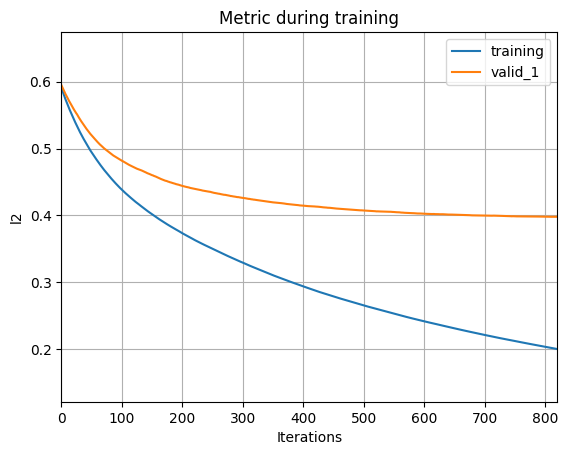

----> || Train Optimized QWK SCORE ::  0.824
----> || Val Optimized QWK SCORE ::  0.562
----> || Train Optimized Val QWK SCORE ::  0.552
----> || Val Optimized Train QWK SCORE ::  0.821
Fold 1 - Rounded Train QWK: 0.7445, Rounded Validation QWK: 0.4313


<Figure size 640x480 with 0 Axes>

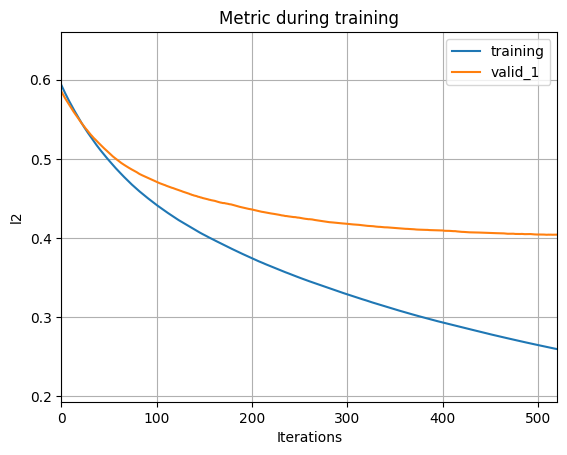

----> || Train Optimized QWK SCORE ::  0.751
----> || Val Optimized QWK SCORE ::  0.547
----> || Train Optimized Val QWK SCORE ::  0.530
----> || Val Optimized Train QWK SCORE ::  0.741
Fold 2 - Rounded Train QWK: 0.6622, Rounded Validation QWK: 0.4490


<Figure size 640x480 with 0 Axes>

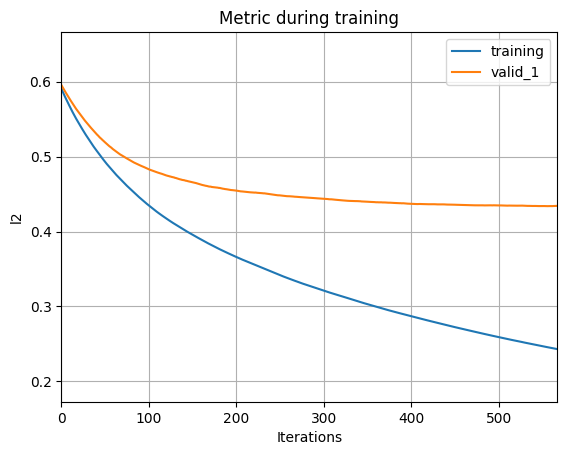

----> || Train Optimized QWK SCORE ::  0.769
----> || Val Optimized QWK SCORE ::  0.521
----> || Train Optimized Val QWK SCORE ::  0.509
----> || Val Optimized Train QWK SCORE ::  0.754
Fold 3 - Rounded Train QWK: 0.6704, Rounded Validation QWK: 0.4275


<Figure size 640x480 with 0 Axes>

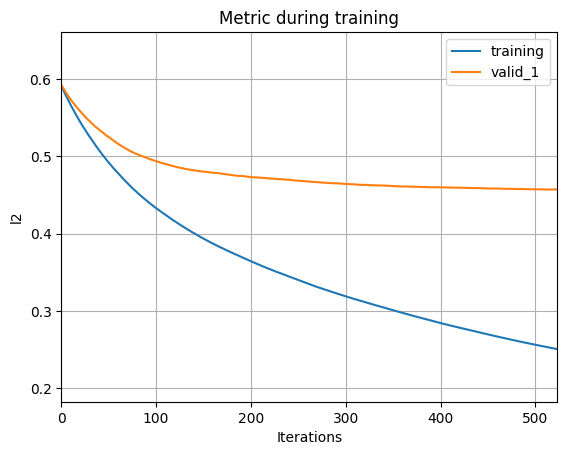

----> || Train Optimized QWK SCORE ::  0.758
----> || Val Optimized QWK SCORE ::  0.391
----> || Train Optimized Val QWK SCORE ::  0.458
----> || Val Optimized Train QWK SCORE ::  0.688
Fold 4 - Rounded Train QWK: 0.6770, Rounded Validation QWK: 0.3663


<Figure size 640x480 with 0 Axes>

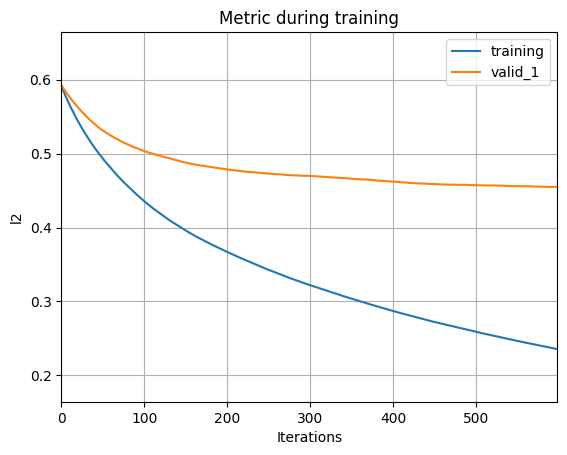

----> || Train Optimized QWK SCORE ::  0.770
----> || Val Optimized QWK SCORE ::  0.441
----> || Train Optimized Val QWK SCORE ::  0.421
----> || Val Optimized Train QWK SCORE ::  0.767
Fold 5 - Rounded Train QWK: 0.6877, Rounded Validation QWK: 0.3724
Mean Train QWK --> 0.7743
Mean Validation QWK ---> 0.4925
----> || Optimized QWK SCORE ::  0.497


In [311]:
lgb_params = {
    'verbosity': -1,
    'seed': SEED,
    'learning_rate': 0.01,
    'num_iterations': 3000,
    'early_stopping_round': 10,
    'max_depth': 12,
    'min_data_in_leaf': 40,
    'num_leaves': 20,
    'min_gain_to_split': 0.05,
    'feature_fraction': 0.8,
    #'bagging_fraction': 0.784,
    #'bagging_freq': 4,
    'lambda_l1': 2,
    'lambda_l2': 50,
    'device': 'gpu'
}

lgb_models_list, lgb_submission_df, lgb_raw_train_preds, lgb_raw_test_preds = lgb_train(lgb_params, train_final_df, test_final_df)

In [ ]:
#submission_df.to_csv('submission.csv', index=False)